# Provision Audio

## module import

In [1]:
import parselmouth
from parselmouth import praat
from parselmouth.praat import call
import os
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import librosa
import librosa.display
import sounddevice as sd
from datetime import datetime
from tqdm import tqdm
import seaborn as sns
import matplotlib.patches as patches
from pathlib import Path

### Hyperparameter

In [2]:
F1_MIN, F1_MAX = 200, 1200    # F1 범위 (Hz)
F2_MIN, F2_MAX = 500, 3000   # F2 범위 (Hz)

## Word Level Analysis

In [3]:
# 소스 코드 기준 상대 경로를 이용하여 proj_dir 위치 설정.
proj_dir = os.path.dirname(os.path.dirname(Path.cwd()))

# wav_dir, annotation_dir 위치 지정.
model_wav_dir = os.path.join(proj_dir, 'data', 'experiment_data', 'model_talker', 'KFA_audio')
model_annotation_dir = os.path.join(proj_dir, 'data', 'experiment_data', 'model_talker', 'KFA_annotation_edited')

# 파일 리스트 가져오기.
model_audio_list = os.listdir(model_wav_dir)
model_annotation_list = os.listdir(model_annotation_dir)

# 파일 확장자 확인하여 파일 리스트 가져오기.
model_audio_list = [file for file in model_audio_list if file.endswith(".wav")]
model_audio_list.sort()


model_annotation_list = [file for file in model_annotation_list if file.endswith(".TextGrid")]
model_annotation_list.sort()

# 리스트 확인
model_audio_list, model_annotation_list

(['난색.wav',
  '난파.wav',
  '내빈.wav',
  '내사.wav',
  '녹각.wav',
  '논개.wav',
  '누룩.wav',
  '누진.wav',
  '닌자.wav',
  '닝닝.wav',
  '말미.wav',
  '망루.wav',
  '매복.wav',
  '맹호.wav',
  '몰딩.wav',
  '몽매.wav',
  '무골.wav',
  '무운.wav',
  '미비.wav',
  '밀사.wav',
  '박애.wav',
  '발탁.wav',
  '백태.wav',
  '뱃심.wav',
  '복시.wav',
  '봉독.wav',
  '분개.wav',
  '불모.wav',
  '비재.wav',
  '빈축.wav',
  '상기.wav',
  '상록.wav',
  '새참.wav',
  '샐쭉.wav',
  '소조.wav',
  '송부.wav',
  '수하.wav',
  '술책.wav',
  '시문.wav',
  '실족.wav',
  '파군.wav',
  '판본.wav',
  '패물.wav',
  '팽배.wav',
  '포문.wav',
  '폭압.wav',
  '품띠.wav',
  '풍산.wav',
  '피폭.wav',
  '필생.wav'],
 ['난색.TextGrid',
  '난파.TextGrid',
  '내빈.TextGrid',
  '내사.TextGrid',
  '녹각.TextGrid',
  '논개.TextGrid',
  '누룩.TextGrid',
  '누진.TextGrid',
  '닌자.TextGrid',
  '닝닝.TextGrid',
  '말미.TextGrid',
  '망루.TextGri

In [4]:
# 단어 자극이 50개이므로 확인할 것.
len(model_audio_list), len(model_annotation_list)

(50, 50)

In [5]:
# any를 사용해서 wav 파일들 중 TextGrid랑 pair가 맞지 않는 경우가 있는지 check.
any([True if wav_file_name.replace('.wav', '.TextGrid') not in model_annotation_list else False for wav_file_name in model_audio_list])

False

In [6]:
class TextGridReader:
    def __init__(self, textgrid_path):
        self.textgrid_path = textgrid_path
        self.tiers_data = {}
        self.file_info = {}
        
    def read(self):
        """
        TextGrid 파일을 읽어서 구조화된 데이터로 변환
        """
        if not os.path.exists(self.textgrid_path):
            raise FileNotFoundError(f"{self.textgrid_path} is not valid path. Please check the file path.")
        
        with open(self.textgrid_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
            
            # 파일 정보 읽기
            self._read_file_info(lines)
            
            # tier 정보 읽기
            self._read_tiers(lines)
            
        return self.tiers_data
    
    def _read_file_info(self, lines):
        """
        파일의 기본 정보 읽기
        """
        for line in lines:
            line = line.strip()
            if '=' in line:
                key, value = line.split('=', 1)
                key = key.strip()
                value = value.strip().strip('"')
                self.file_info[key] = value
    
    def _read_tiers(self, lines):
        """
        tier 정보 읽기
        """
        current_tier = None
        current_intervals = []
        reading_interval = False
        interval_data = {}
        
        for line in lines:
            line = line.strip()
            
            # tier 시작
            if 'name = "' in line:
                if current_tier is not None:
                    self.tiers_data[current_tier] = current_intervals
                current_tier = line.split('"')[1]
                current_intervals = []
                reading_interval = False
            
            # interval 시작
            elif 'intervals [' in line:
                reading_interval = True
                interval_data = {}
            
            # interval 데이터 읽기
            elif reading_interval and '=' in line:
                key, value = line.split('=', 1)
                key = key.strip()
                value = value.strip().strip('"')
                interval_data[key] = value
                
                # interval 완성
                if 'text' in interval_data:
                    start = float(interval_data['xmin'])
                    end = float(interval_data['xmax'])
                    text = interval_data['text']
                    current_intervals.append((start, end, text))
                    reading_interval = False
        
        # 마지막 tier 추가
        if current_tier is not None:
            self.tiers_data[current_tier] = current_intervals
    
    def get_tier_names(self):
        """
        tier 이름 목록 반환
        """
        return list(self.tiers_data.keys())
    
    def get_intervals_by_tier(self, tier_name):
        """
        특정 tier의 interval 목록 반환
        """
        return self.tiers_data.get(tier_name, [])
    
    def get_total_duration(self):
        """
        전체 음성 길이 반환
        """
        return float(self.file_info.get('xmax', 0))

In [7]:
class FormantAnalyzer:
    def __init__(self, wav_dir, annotation_dir, file_list):
        self.target_tier = 'phone'
        self.allowed_vowels = ['a', 'e', 'i', 'o', 'u', 'ae']

        self.wav_dir = wav_dir
        self.annotation_dir = annotation_dir
        self.file_list = file_list
        
        self.check_file_validity()
        
    
    # 동명의 wav, textGrid 파일이 존재하는지 확인.
    def check_file_validity(self):
        # file_list에서 file name을 가져와서 wav file, TextGrid file이 존재하는지 확인.
        for file_name in self.file_list:
            # 파일명은 textGrid이던, wav이던 상관없이 valid.
            wav_file_path = os.path.join(self.wav_dir, file_name.replace('.TextGrid', '.wav'))
            annotation_file_path = os.path.join(self.annotation_dir, file_name.replace('.wav', '.TextGrid'))
            
            if not os.path.exists(wav_file_path) or not os.path.exists(annotation_file_path):
                raise FileNotFoundError(f"{file_name} is not valid")
            
        print(f"Every files are valid.")
    
    def parse_textGrid(self, file_name):
        if file_name.endswith('.wav'):
            file_name = file_name.replace('.wav', '.TextGrid')

        file_path = os.path.join(self.annotation_dir, file_name)

        if not os.path.exists(file_path):
            raise FileNotFoundError(f"{file_name} is not valid path. Please check the file path.")
        
        reader = TextGridReader(file_path)
        reader.read()
        return reader.tiers_data
    
    def formant_analysis(self, filename, interval:tuple[float, float]):
        # file validity check
        wav_path = os.path.join(self.wav_dir, filename.replace('.TextGrid', '.wav'))
        textgrid_path = os.path.join(self.annotation_dir, filename.replace('.wav', '.TextGrid'))

        if not os.path.exists(wav_path):
            raise FileNotFoundError(f"wav_file is not valid. Please check the {wav_path} path.")

        if not os.path.exists(textgrid_path):
            raise FileNotFoundError(f"textgrid_file is not valid. Please check the {textgrid_path} path.")
        
        # interval 정보 확인.
        start_sec, end_sec = interval

        # 포먼트 추출 (Burg 방식 사용)
        step=0.01 # window_size
        n_formants = 5 # f1~f5까지 calculate.
        sound = parselmouth.Sound(wav_path)
        formant = sound.to_formant_burg(time_step=step, max_number_of_formants=n_formants, maximum_formant=5000, window_length=0.025, pre_emphasis_from=50)
        times = np.arange(start_sec, end_sec, step)
        formant_values = [[] for _ in range(n_formants)]
        
        for t in times:
            for i in range(n_formants):
                value = formant.get_value_at_time(i+1, t)
                if value is not None and np.isfinite(value):
                    formant_values[i].append(value)
        
        # 평균값 반환
        return [np.mean(f) if len(f) > 0 else np.nan for f in formant_values]
    
    
    def analyze(self):
        pass

    def analyze_all(self):
        pass

In [8]:
model_audio_list[0]

'난색.wav'

In [9]:
vowel_formants_df = pd.DataFrame(columns=['file_name', 'vowel', 'f1', 'f2'], index=[])
vowel_formants_df

,file_name,vowel,f1,f2


In [10]:
f_analyzer = FormantAnalyzer(model_wav_dir, model_annotation_dir, model_audio_list)

# 모든 textGrid 파일이 잘 읽혔는지 확인.
# 간혹 가다가 안 읽혔다면, 파일 크기를 확인해봐라. 
# 아주대 측에서 보낸 파일들 중 크기가 유난히 작은게 있다면 파일 메타데이터가 소실된 것.
# 당황하지 말고 praat로 해당 textgrid, wav 동시에 열고 다시 textgrid 저장해서 덮어쓸 것.
# 그러면 praat가 제대로 다시 정보를 저장할 거다.
for file in model_audio_list:
    if not ('phone' in f_analyzer.parse_textGrid(file)):
        raise ValueError(f"{file} is not valid file. Please check the file path.")
    phone_info_list = f_analyzer.parse_textGrid(file)['phone']
    for phone_info in phone_info_list:
        start_sec, end_sec, phone = phone_info
        if phone in f_analyzer.allowed_vowels:
            vowel_formants = f_analyzer.formant_analysis(file, (start_sec, end_sec))
            vowel_formants_df = pd.concat([vowel_formants_df, pd.DataFrame({'file_name': [file], 'vowel': [phone], 'f1': [vowel_formants[0]], 'f2': [vowel_formants[1]]})], ignore_index=True)
            #print(f"Vowel: {phone}, F1: {vowel_formants[0]}, F2: {vowel_formants[1]}")
print('Evey files has a 2 tier info(phone, word).')
vowel_formants_df

Every files are valid.


/var/folders/3t/7cyq0j713bn7qcyfypl8dx3w0000gn/T/ipykernel_19056/4121085475.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  vowel_formants_df = pd.concat([vowel_formants_df, pd.DataFrame({'file_name': [file], 'vowel': [phone], 'f1': [vowel_formants[0]], 'f2': [vowel_formants[1]]})], ignore_index=True)


Evey files has a 2 tier info(phone, word).


,file_name,vowel,f1,f2
0,난색.wav,a,592.648222,1295.456312
1,난색.wav,ae,421.229279,1979.494702
2,난파.wav,a,590.626505,1178.091078
3,난파.wav,a,634.559286,1436.505071
4,내빈.wav,ae,398.511565,1841.053686
...,...,...,...,...
95,풍산.wav,a,593.318107,1358.359943
96,피폭.wav,i,338.245922,1927.591282
97,피폭.wav,o,392.578648,637.801515
98,필생.wav,i,334.830133,1913.578560


In [11]:
data_dir = os.path.join(os.path.dirname(os.path.dirname(Path.cwd())), 'data', 'experiment_data', 'model_talker')
vowel_formants_df.to_excel(os.path.join(data_dir, 'vowel_formants_df.xlsx'), index=False)

In [12]:
formant_df = pd.read_excel(os.path.join(data_dir, 'vowel_formants_df.xlsx'))
formant_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   file_name  100 non-null    object 
 1   vowel      100 non-null    object 
 2   f1         100 non-null    float64
 3   f2         100 non-null    float64
dtypes: float64(2), object(2)
memory usage: 3.3+ KB


In [13]:
formant_df['vowel'] = formant_df['vowel'].astype('category')
formant_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   file_name  100 non-null    object  
 1   vowel      100 non-null    category
 2   f1         100 non-null    float64 
 3   f2         100 non-null    float64 
dtypes: category(1), float64(2), object(1)
memory usage: 2.8+ KB


In [14]:
formant_df.groupby('vowel')['f1'].mean()

/var/folders/3t/7cyq0j713bn7qcyfypl8dx3w0000gn/T/ipykernel_19056/2998748369.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  formant_df.groupby('vowel')['f1'].mean()


vowel
a     578.414245
ae    443.926535
i     348.367164
o     378.683382
u     367.503783
Name: f1, dtype: float64

In [15]:
formant_df.groupby('vowel')['f2'].mean()

/var/folders/3t/7cyq0j713bn7qcyfypl8dx3w0000gn/T/ipykernel_19056/3075367221.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  formant_df.groupby('vowel')['f2'].mean()


vowel
a     1239.910385
ae    1901.797140
i     2079.479478
o      893.053902
u     1257.655762
Name: f2, dtype: float64

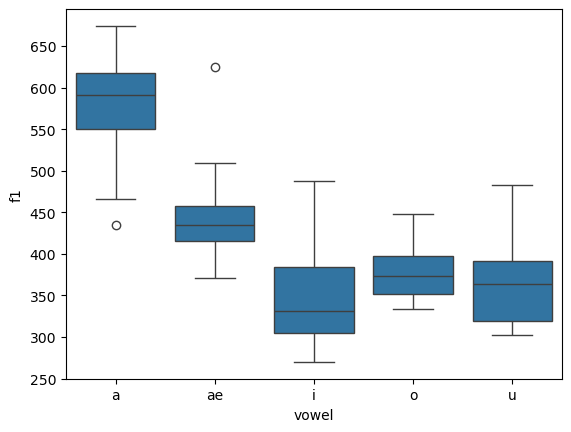

In [16]:
sns.boxplot(data=formant_df, x='vowel', y='f1')
plt.show()

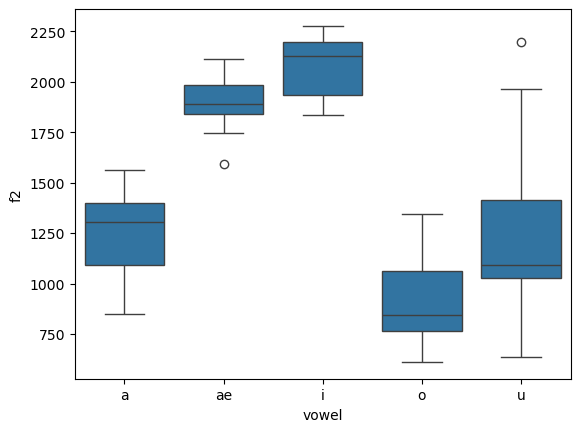

In [17]:
sns.boxplot(data=formant_df, x='vowel', y='f2')
plt.show()

In [18]:
def formant_analysis(file_Path, audio_name, start_time=0, end_time=0, time_step=0.01):
    # WAV 파일 불러오기
    print("filePath", file_Path)
    print("audio_name", audio_name)
    sound = parselmouth.Sound(os.path.join(file_Path, audio_name))
    if end_time == 0:
        end_time = sound.duration
    
    if time_step == -1:
        if start_time !=0 and end_time !=0:
            time_step = end_time - start_time
        else:
            time_step = sound.duration
    #print(sound.duration)
    # 평균 음원 길이 약 .7s 정도
    #time_step = 0.01
    time_points = np.arange(start_time, end_time, time_step)
    f1_list = []
    f2_list = []
    
    # 포먼트 추출 (Burg 방식 사용)
    formants = sound.to_formant_burg(time_step=time_step, 
                                    max_number_of_formants=5.0,
                                    maximum_formant=5000.0, 
                                    window_length=0.025, 
                                    pre_emphasis_from=50.0)

    for time_point in time_points:
        # 특정 시간에서의 F1, F2 값 추출
        f1 = formants.get_value_at_time(1, time_point)
        f2 = formants.get_value_at_time(2, time_point)
        f1_list.append(f1)
        f2_list.append(f2)

        """
        if (f1 and f2 and 
            np.isfinite(f1) and np.isfinite(f2) and
            F1_MIN <= f1 <= F1_MAX and 
            F2_MIN <= f2 <= F2_MAX and 
            (f2 - f1) >= 200):  # F2-F1 최소 차이
            f1_list.append(f1)
            f2_list.append(f2)
        """


    formant_df = pd.DataFrame({"f1": f1_list, "f2": f2_list, "time": time_points})
    return formant_df


def plot_formant_distribution(audio_name, file_Path, ax=None, start_time=0, end_time=0):    
    # 고정된 축 범위 설정
    F1_MIN, F1_MAX = 200, 1200    # F1 범위 (Hz)
    F2_MIN, F2_MAX = 500, 3000   # F2 범위 (Hz)
    
    # take formant list
    formant_df = formant_analysis(file_Path, audio_name, start_time, end_time)

    # 산점도 그리기
    scatter = sns.scatterplot(data=formant_df, 
                         x="f1", 
                         y="f2", 
                         hue="time", 
                         palette="viridis", 
                         alpha=0.5, 
                         s=50,
                         ax=ax)

    # 축 반전 (언어학 관례)
    #ax.invert_xaxis()
    #ax.invert_yaxis()

    # 축 범위 설정
    ax.set_xlim(F1_MAX, F1_MIN)  # F2 축 반전
    ax.set_ylim(F2_MAX, F2_MIN)  # F1 축 반전
    
    # 제목과 레이블 설정
    ax.set_title(f'포먼트 분포도: {audio_name}', fontsize=12, pad=10)
    ax.set_xlabel('F1 (Hz)', fontsize=10)
    ax.set_ylabel('F2 (Hz)', fontsize=10)

    # 컬러바 설정
    norm = plt.Normalize(formant_df['time'].min(), formant_df['time'].max())
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax).set_label('시간 (초)', fontsize=8)

    # 그리드 설정
    ax.grid(True, linestyle='--', alpha=0.7)
    
    return formant_df

In [34]:
audio_list = [file for file in os.listdir(os.path.join(os.path.dirname(os.path.dirname(Path.cwd())), 'data', 'audio', 'audio-sample', 'short-version-phonetic')) if file.endswith('.wav')]
len(audio_list)

50

In [35]:
filePath = os.path.join(os.path.dirname(os.path.dirname(Path.cwd())), 'data', 'audio', 'audio-sample', 'short-version-phonetic')

filePath /Users/bagjuhyeon/Documents/WorkSpace/phoneticConvergence/data/audio/audio-sample/short-version-phonetic
audio_name 분개.wav
filePath /Users/bagjuhyeon/Documents/WorkSpace/phoneticConvergence/data/audio/audio-sample/short-version-phonetic
audio_name 상록.wav
filePath /Users/bagjuhyeon/Documents/WorkSpace/phoneticConvergence/data/audio/audio-sample/short-version-phonetic
audio_name 밀사.wav
filePath /Users/bagjuhyeon/Documents/WorkSpace/phoneticConvergence/data/audio/audio-sample/short-version-phonetic
audio_name 무골.wav
filePath /Users/bagjuhyeon/Documents/WorkSpace/phoneticConvergence/data/audio/audio-sample/short-version-phonetic
audio_name 패물.wav
filePath /Users/bagjuhyeon/Documents/WorkSpace/phoneticConvergence/data/audio/audio-sample/short-version-phonetic
audio_name 송부.wav
filePath /Users/bagjuhyeon/Documents/WorkSpace/phoneticConvergence/data/audio/audio-sample/short-version-phonetic
audio_name 내빈.wav
filePath /Users/bagjuhyeon/Documents/WorkSpace/phoneti

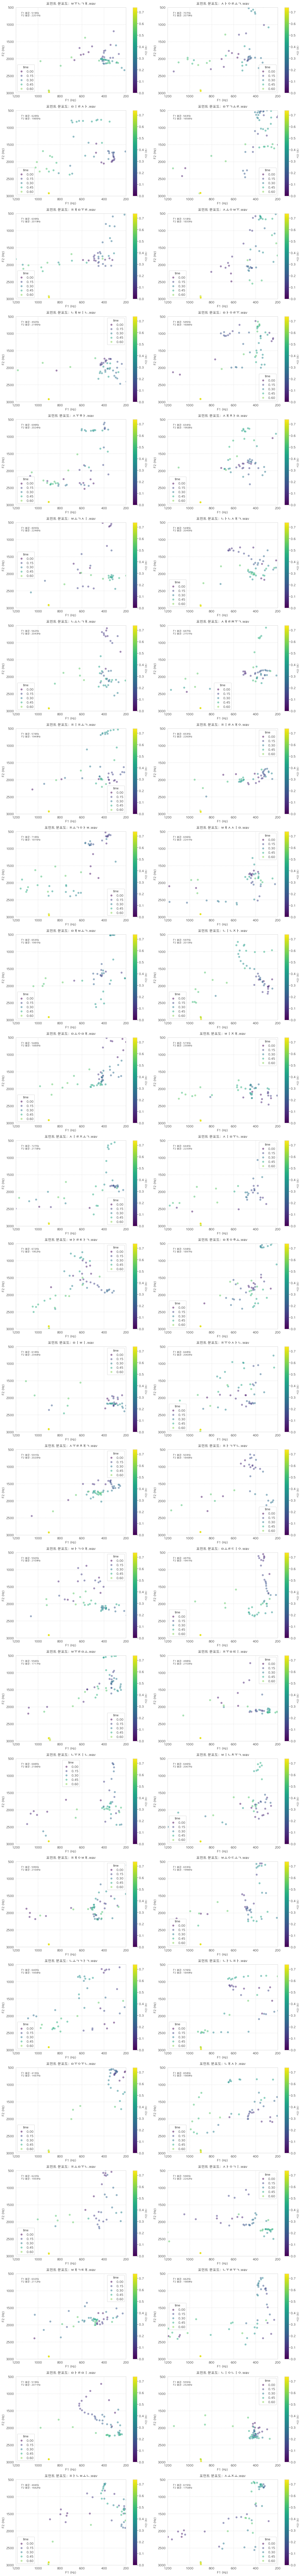

In [36]:
# 메인 코드
# 기본 스타일 설정
sns.set_style("whitegrid")
# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = ['AppleGothic']  # macOS의 경우
#plt.rcParams['font.family'] = 'sans-serif'


# 서브플롯 개수 계산
n_plots = len(audio_list)
n_cols = 2  # 열 개수 지정
n_rows = (n_plots + 1) // 2  # 행 개수 계산 (올림)

# Figure 생성
fig = plt.figure(figsize=(15, 5*n_rows))

# 각 오디오 파일에 대해 서브플롯 생성
for idx, audio_name in enumerate(audio_list, 1):
    ax = fig.add_subplot(n_rows, n_cols, idx)
    formant_df = plot_formant_distribution(audio_name, filePath, ax)
    
    # 통계 정보를 타이틀 아래에 추가 (선택사항)
    stats = formant_df.describe().round(2)
    ax.text(0.05, 0.95, 
            f'F1 평균: {stats["f1"]["mean"]:.0f}Hz\nF2 평균: {stats["f2"]["mean"]:.0f}Hz',
            transform=ax.transAxes,
            fontsize=8,
            verticalalignment='top')

# 전체 레이아웃 조정
plt.tight_layout()
plt.show()

In [6]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def visualize_phoneme_segmentation(audio_path, method='librosa', start_time=None, end_time=None):
    # 오디오 로드
    if start_time is not None and end_time is not None:
        # 방법 2: offset과 duration 파라미터 사용
        duration = end_time - start_time
        y, sr = librosa.load(audio_path, sr=None, offset=start_time, duration=duration)
    elif start_time is not None:
        # start_time만 있는 경우
        y, sr = librosa.load(audio_path, sr=None, offset=start_time)
    else:
        # 전체 오디오 로드
        y, sr = librosa.load(audio_path, sr=None)
    
    # 시간 축 범위 설정 (모든 서브플롯에 공통으로 적용)
    time_max = len(y) / sr
    time_axis = np.linspace(0, time_max, len(y))
    
    if method == 'librosa':
        # MFCC 특성 추출 - hop_length 통일
        hop_length = 256
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=hop_length)
        print(mfcc.shape)
        
        # 델타 특성 (변화량)
        mfcc_delta = librosa.feature.delta(mfcc)
        
        # 변화량이 큰 지점을 음소 경계로 추정
        changes = np.sum(np.abs(mfcc_delta), axis=0)
        distance = 10
        peaks, _ = find_peaks(changes, height=np.std(changes)*1.0, distance=distance)
        
        # 시간 단위로 변환 - 동일한 hop_length 사용
        boundaries = librosa.frames_to_time(peaks, sr=sr, hop_length=hop_length)
    
    # 결과 시각화
    fig = plt.figure(figsize=(15, 10))
    
    # 파형 플롯
    ax1 = plt.subplot(3, 1, 1)
    librosa.display.waveshow(y, sr=sr, ax=ax1)
    ax1.set_title('파형 (Waveform)', fontsize=12)
    ax1.set_xlabel('시간 (초)', fontsize=10)
    ax1.set_ylabel('진폭', fontsize=10)
    ax1.set_xlim(0, time_max)
    
    # 경계 표시
    for boundary in boundaries:
        ax1.axvline(x=boundary, color='r', linestyle='--', alpha=0.7)
    
    # 스펙트로그램 플롯
    ax2 = plt.subplot(3, 1, 2, sharex=ax1)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    img = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', ax=ax2)
    fig.colorbar(img, ax=ax2, format='%+2.0f dB')
    ax2.set_title('스펙트로그램 (Spectrogram)', fontsize=12)
    ax2.set_xlabel('시간 (초)', fontsize=10)
    ax2.set_ylabel('주파수 (Hz)', fontsize=10)
    ax2.set_xlim(0, time_max)
    
    # 경계 표시
    for boundary in boundaries:
        ax2.axvline(x=boundary, color='r', linestyle='--', alpha=0.7)
    
    # MFCC 변화량
    ax3 = plt.subplot(3, 1, 3, sharex=ax1)
    # 동일한 hop_length 사용하여 시간 계산
    times = librosa.times_like(changes, sr=sr, hop_length=hop_length)
    ax3.plot(times, changes)
    ax3.set_title('MFCC 변화량 (MFCC Delta Sum)', fontsize=12)
    ax3.set_xlabel('시간 (초)', fontsize=10)
    ax3.set_ylabel('변화량 크기 (Delta Magnitude)', fontsize=10)
    ax3.set_xlim(0, time_max)
    
    # 피크(경계) 표시
    for boundary in boundaries:
        ax3.axvline(x=boundary, color='r', linestyle='--', alpha=0.7)
    
    # x축 통일을 위한 추가 설정 - 명시적으로 모든 서브플롯에 동일한 범위 적용
    plt.setp([ax1, ax2, ax3], xlim=(0, time_max))
    
    # 레이아웃 조정 및 서브플롯 간 간격 설정
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4)
    
    # 음소 경계에 레이블 추가
    for i, boundary in enumerate(boundaries):
        if boundary <= time_max:  # 범위 내에 있는 경계만 레이블 추가
            ax3.annotate(f"{i+1}", 
                         xy=(boundary, max(changes) * 0.9),
                         xytext=(0, 5), 
                         textcoords='offset points',
                         ha='center',
                         fontsize=8)
    
    # 경계선 범례 추가
    ax1.plot([], [], 'r--', alpha=0.7, label='음소 경계')
    ax1.legend(loc='upper right')
    
    plt.show()
    
    # 경계 시간 출력
    print(f"총 {len(boundaries)}개의 음소 경계 탐지")
    for i, boundary in enumerate(boundaries):
        print(f"음소 경계 {i+1}: {boundary:.3f}초")
    
    return boundaries

In [9]:
segment_idx = 0
sample_y, sample_sr = librosa.load(audio_path)
#play_audio_segment(y=sample_y, sr=sample_sr, start_time=segments[segment_idx], end_time=segments[segment_idx+1])
play_audio_segment(y=sample_y, sr=sample_sr, start_time=segments[0], end_time=segments[1])

NameError: name 'play_audio_segment' is not defined

In [80]:
data

,f1,f2,time
0,459.772505,1993.640636,0.446984
0,459.772505,1993.640636,0.063855
0,459.772505,1993.640636,0.162540
0,459.772505,1993.640636,0.272834
0,459.772505,1993.640636,0.336689
0,459.772505,1993.640636,0.446984


In [1113]:
segments

array([0.06385488, 0.16253968, 0.27283447, 0.33668934, 0.44698413,
       0.55147392])

In [38]:
sample_y, sample_sr = librosa.load(audio_path)
sample_y.shape

(16384,)

In [2465]:
def detect_syllable_boundaries(sound, threshold_db=-50, min_silence_duration=0.05):
    """
    음성(sound)에서 intensity(< threshold_db dB) 구간이 min_silence_duration 이상 연속되는
    지점을 무음(silence) 경계로 검출하여, 경계 리스트를 반환.
    """
    intensity = sound.to_intensity()  # dB 단위 intensity 객체 생성  [oai_citation:0‡parselmouth.readthedocs.io](https://parselmouth.readthedocs.io/en/latest/api/parselmouth.Formant.html?utm_source=chatgpt.com)
    times = intensity.xs()
    values = intensity.values[0]       # intensity.values: shape=(1, N)
    
    # threshold 이하인 프레임 마스크
    low_mask = values < threshold_db
    # 연속 구간 탐색
    boundaries = []
    start_idx = None
    for i, is_low in enumerate(low_mask):
        if is_low and start_idx is None:
            start_idx = i
        elif not is_low and start_idx is not None:
            dur = times[i-1] - times[start_idx]
            if dur >= min_silence_duration:
                midpoint = (times[start_idx] + times[i-1]) / 2
                boundaries.append(midpoint)
            start_idx = None
    # 파일 끝에서 종료된 경우 처리
    if start_idx is not None:
        dur = times[-1] - times[start_idx]
        if dur >= min_silence_duration:
            midpoint = (times[start_idx] + times[-1]) / 2
            boundaries.append(midpoint)
    return boundaries

# 사용 예시
snd = parselmouth.Sound(audio_path)
silence_points = detect_syllable_boundaries(snd)

In [2466]:
silence_points

[np.float64(0.6395192743764173)]

# Exp Audio

## word-level

In [3]:
def tokenization_audio2word(filePath):
    # 실험 결과 폴더 접근.
    for filename in os.listdir(filePath):
        # 특정 참가자 폴더 접근.
        if filename.startswith("participant_"):
            participant_folder = os.path.join(filePath, filename)
        else:
            pass

        # 참가자 폴더 내의 모든 wav 파일 접근.
        if len(os.listdir(participant_folder)) != 6:
            print(f"{filename} 폴더 내의 모든 wav 파일 개수가 6개가 아닙니다.")
            raise ValueError("참가자 폴더 내의 모든 wav 파일 개수가 6개가 아닙니다.")

        # 참가자 폴더 내의 모든 wav 파일 접근.  
        for file in os.listdir(participant_folder):
            # 
            if file.endswith(".wav"):
                print(file)

expFilePath = "../../../../Desktop/results"
participants_list = os.listdir(expFilePath)
print(participants_list)

"""
for participant in participants_list:
    filePath = os.path.join(expFilePath, participant)
    tokenization_audio2word(filePath)
"""

['participant_test0001', '.DS_Store', 'participant_LY017', 'participant_LY028', 'participant_LY010', 'participant_LY026', 'participant_LY019', 'participant_LY021', 'participant_LY027', 'participant_LY018', 'participant_LY016', 'participant_LY029', 'participant_LY034', 'survey.xlsx', 'participant_LY033', 'pilot-02', 'participant_LY005', 'participant_LY002', 'participant_LY003', 'participant_LY004', 'participant_LY032', 'participant_LY035', '~$survey.xlsx', 'participant_LY011(v)', 'participant_LY001(v)', 'participant_LY022(v)', 'participant_LY013', 'participant_LY014', 'participant_LY025', 'participant_LY040', 'participant_LY024', 'participant_LY023', 'participant_LY015', 'participant_LY012', 'participant_test001', 'participant_LY037', 'participant_LY039', 'pilot-01', 'participant_LY006', 'participant_LY038', 'participant_LY007', 'participant_LY009', 'participant_LY036', 'participant_LY031']


'\nfor participant in participants_list:\n    filePath = os.path.join(expFilePath, participant)\n    tokenization_audio2word(filePath)\n'

In [4]:
def load_audio(file_path: str):
    """
    오디오 파일을 로드합니다.
    
    Args:
        file_path (str): 오디오 파일 경로
    
    Returns:
        tuple: (y, sr) 오디오 데이터와 샘플링 레이트
    """
    try:
        # librosa를 사용하여 오디오 로드
        y, sr = librosa.load(file_path, sr=44100)
        return y, sr
    except Exception as e:
        print(f"오디오 로드 중 오류 발생: {str(e)}")
        # parselmouth를 사용하여 대체 로드 시도
        try:
            sound = parselmouth.Sound(file_path)
            y = sound.values
            sr = sound.sampling_frequency
            return y, sr
        except Exception as e2:
            print(f"대체 로드 중 오류 발생: {str(e2)}")
            raise

In [5]:
def play_audio_segment(y, sr:int, start_time:float, end_time:float):
    """
    오디오의 특정 구간을 재생합니다.
    
    Args:
        y (np.ndarray): 오디오 데이터
        sr (int): 샘플링 레이트
        start_time (float): 시작 시간 (초)
        end_time (float): 종료 시간 (초)
    """
    sd._terminate()
    sd._initialize()
    sd.query_devices()
    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)
    segment = y[start_sample:end_sample]
    
    print("재생 중...", end='', flush=True)
    sd.play(segment, sr)
    sd.wait()
    print(" 완료")

In [6]:
def check_excel_info(file_path):
    """
    엑셀 파일의 시트 정보를 확인합니다.
    
    Args:
        file_path (str): 엑셀 파일 경로
    """
    try:
        # 엑셀 파일의 모든 시트 정보 가져오기
        excel_file = pd.ExcelFile(file_path)
        sheet_names = excel_file.sheet_names
        
        print(f"\n파일명: {os.path.basename(file_path)}")
        print(f"총 시트 수: {len(sheet_names)}")
        print("\n시트 목록:")
        for i, sheet_name in enumerate(sheet_names, 1):
            # 각 시트의 기본 정보 가져오기
            df = pd.read_excel(file_path, sheet_name=sheet_name)
            print(f"\n{i}. 시트명: {sheet_name}")
            print(f"   - 행 수: {len(df)}")
            print(f"   - 열 수: {len(df.columns)}")
            print(f"   - 열 이름: {list(df.columns)}")
            
    except Exception as e:
        print(f"오류 발생: {str(e)}")

In [7]:
from pydub import AudioSegment, silence
import os

def word_segmentation(audio_path: str, excel_path: str):

    #result
    start_time_list = []
    end_time_list = []

    # load audio(Sequential file format)
    y, sr = load_audio(audio_path)
    # load audio(AudioSegment)
    audio = AudioSegment.from_file(audio_path)

    # detect nonsilent ranges
    nonsilent_ranges = silence.detect_nonsilent(audio, min_silence_len=380, silence_thresh=-49, seek_step=1)
    """
    audio: 오디오 파일, 위에서 load한 결과물
    min_silence_len: 최소 묵음 길이 (ms), 이 길이보다 짧은 묵음은 무시
    silence_thresh: 묵음 임계치 (dB), 이 값보다 작은 값은 묵음으로 판단
    seek_step: 탐색 단계 (ms), 탐색 단계만큼 건너뛰어 탐색
    """

    print(f"detected segments: {len(nonsilent_ranges)}")

    # play audio segment
    for start_ms, end_ms in nonsilent_ranges:
        # padding for ending time
        padding = 0.2
        start_sec = start_ms / 1000
        start_sec = start_sec - padding if start_sec - padding > 0 else 0
        end_sec = end_ms / 1000 
        end_sec = end_sec + padding if end_sec + padding < audio.duration_seconds else audio.duration_seconds

        # append result
        start_time_list.append(start_sec)
        end_time_list.append(end_sec)

        # play audio segment
        #play_audio_segment(y=y, sr=sr, start_time=start_sec, end_time=end_sec)
        print(f"시작: {start_sec:.2f}초, 끝: {end_sec:.2f}초")
    return start_time_list, end_time_list

In [8]:
def save_excel(excel_path, sheet_name, start_time_list, end_time_list):
    sheet = pd.read_excel(excel_path, sheet_name=sheet_name)
    sheet['start_time'] = start_time_list
    sheet['end_time'] = end_time_list

    with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
        sheet.to_excel(writer, sheet_name=sheet_name, index=False)

In [9]:
"""
expPath = "../../../../Desktop/results"
participants_list = os.listdir(expPath)
participants_list = [participant for participant in participants_list if participant.startswith("participant_")]
participants_list.sort()

for participant in participants_list:
    # access to the participant folder
    participant_path = os.path.join(expPath, participant)

    # check the folder is ready to analyze
    wav_file_list = os.listdir(participant_path)
    wav_file_list = [file for file in wav_file_list if file.endswith(".wav")]
    if len(wav_file_list) != 6:
        print(f"{participant} 폴더 내의 모든 wav 파일 개수가 6개가 아닙니다.")
        continue

    # access to the audio file
    audio_list = [f for f in os.listdir(participant_path) if f.endswith(".wav")]
    audio_list.sort()
    

    # access to the excel file
    excel_file_path = list(os.listdir(participant_path))
    excel_file_path = [file for file in excel_file_path if file.endswith(".xlsx")][0]
    excel_file_path = os.path.join(participant_path, excel_file_path)
    excel_file = pd.ExcelFile(excel_file_path)
    
    # access to the sheet
    for stage_idx, sheet_name in enumerate(excel_file.sheet_names):
        if not 'Stage' in sheet_name:
            continue
        
        audio_path = os.path.join(participant_path, audio_list[stage_idx-1])
        sheet = pd.read_excel(excel_file_path, sheet_name=sheet_name)

        start_time_list, end_time_list = word_segmentation(audio_path, excel_file_path)
        save_excel(excel_file_path, sheet_name, start_time_list, end_time_list)
"""
        

'\nexpPath = "../../../../Desktop/results"\nparticipants_list = os.listdir(expPath)\nparticipants_list = [participant for participant in participants_list if participant.startswith("participant_")]\nparticipants_list.sort()\n\nfor participant in participants_list:\n    # access to the participant folder\n    participant_path = os.path.join(expPath, participant)\n\n    # check the folder is ready to analyze\n    wav_file_list = os.listdir(participant_path)\n    wav_file_list = [file for file in wav_file_list if file.endswith(".wav")]\n    if len(wav_file_list) != 6:\n        print(f"{participant} 폴더 내의 모든 wav 파일 개수가 6개가 아닙니다.")\n        continue\n\n    # access to the audio file\n    audio_list = [f for f in os.listdir(participant_path) if f.endswith(".wav")]\n    audio_list.sort()\n    \n\n    # access to the excel file\n    excel_file_path = list(os.listdir(participant_path))\n    excel_file_path = [file for file in excel_file_path if file.endswith(".xlsx")][0]\n    excel_file_path = 

In [10]:
expPath = "../../../../Desktop/results"
participants_list = os.listdir(expPath)
participants_list = [participant for participant in participants_list if participant.startswith("participant_")]
participants_list.sort()     
participants_list   

['participant_LY001(v)',
 'participant_LY002',
 'participant_LY003',
 'participant_LY004',
 'participant_LY005',
 'participant_LY006',
 'participant_LY007',
 'participant_LY009',
 'participant_LY010',
 'participant_LY011(v)',
 'participant_LY012',
 'participant_LY013',
 'participant_LY014',
 'participant_LY015',
 'participant_LY016',
 'participant_LY017',
 'participant_LY018',
 'participant_LY019',
 'participant_LY021',
 'participant_LY022(v)',
 'participant_LY023',
 'participant_LY024',
 'participant_LY025',
 'participant_LY026',
 'participant_LY027',
 'participant_LY028',
 'participant_LY029',
 'participant_LY031',
 'participant_LY032',
 'participant_LY033',
 'participant_LY034',
 'participant_LY035',
 'participant_LY036',
 'participant_LY037',
 'participant_LY038',
 'participant_LY039',
 'participant_LY040',
 'participant_test0001',
 'participant_test001']

In [11]:
participants_list[7]

'participant_LY009'

In [12]:
def padding_list(start_time_list, end_time_list, target_num):
    padding_num = target_num - len(start_time_list)
    if padding_num > 0:
        for idx in range(padding_num):
            start_time_list.append(start_time_list[-1])
            end_time_list.append(end_time_list[-1])
    else:
        start_time_list = start_time_list[:target_num]
        end_time_list = end_time_list[:target_num]
    return start_time_list, end_time_list

In [15]:
# access to the participant folder
participant = participants_list[17]
participant_path = os.path.join(expPath, participant)

# check the folder is ready to analyze
wav_file_list = os.listdir(participant_path)
wav_file_list = [file for file in wav_file_list if file.endswith(".wav")]

if len(wav_file_list) != 6:
    print(f"{participant} 폴더 내의 모든 wav 파일 개수가 6개가 아닙니다.")
    raise ValueError("참가자 폴더 내의 모든 wav 파일 개수가 6개가 아닙니다.")

# access to the audio file
audio_list = [f for f in os.listdir(participant_path) if f.endswith(".wav")]
audio_list.sort()
    

# access to the excel file
excel_file_path = list(os.listdir(participant_path))
excel_file_path = [file for file in excel_file_path if file.endswith(".xlsx")][0]
excel_file_path = os.path.join(participant_path, excel_file_path)
excel_file = pd.ExcelFile(excel_file_path)
print(participant)
print(excel_file.sheet_names)

participant_LY019
['Info', 'Stage1', 'Stage2', 'Stage3', 'Stage4', 'Stage5', 'Stage6']


In [16]:
# access to the sheet
sheet_num = 4
sheet_name = excel_file.sheet_names[sheet_num]
if not 'Stage' in sheet_name:
    raise ValueError("sheet_name이 올바르지 않습니다.")

audio_path = os.path.join(participant_path, audio_list[sheet_num-1])
sheet = pd.read_excel(excel_file_path, sheet_name=sheet_name)

start_time_list, end_time_list = word_segmentation(audio_path, excel_file_path)

detected segments: 146
시작: 1.39초, 끝: 2.12초
시작: 2.23초, 끝: 3.88초
시작: 4.29초, 끝: 5.25초
시작: 6.61초, 끝: 7.32초
시작: 8.79초, 끝: 10.14초
시작: 10.13초, 끝: 10.90초
시작: 11.52초, 끝: 12.30초
시작: 12.88초, 끝: 13.88초
시작: 15.12초, 끝: 16.34초
시작: 16.77초, 끝: 18.09초
시작: 18.23초, 끝: 19.71초
시작: 19.75초, 끝: 20.80초
시작: 21.24초, 끝: 22.69초
시작: 22.96초, 끝: 24.43초
시작: 24.46초, 끝: 25.83초
시작: 26.03초, 끝: 27.24초
시작: 27.73초, 끝: 29.15초
시작: 29.37초, 끝: 30.67초
시작: 30.93초, 끝: 32.23초
시작: 32.52초, 끝: 33.74초
시작: 33.98초, 끝: 35.17초
시작: 35.40초, 끝: 36.56초
시작: 36.88초, 끝: 37.91초
시작: 38.27초, 끝: 38.97초
시작: 39.59초, 끝: 40.82초
시작: 40.90초, 끝: 42.03초
시작: 43.16초, 끝: 44.55초
시작: 44.58초, 끝: 45.81초
시작: 46.11초, 끝: 47.19초
시작: 47.60초, 끝: 48.91초
시작: 49.25초, 끝: 50.67초
시작: 50.79초, 끝: 53.49초
시작: 53.85초, 끝: 55.19초
시작: 55.36초, 끝: 56.58초
시작: 56.94초, 끝: 58.11초
시작: 58.47초, 끝: 59.62초
시작: 60.03초, 끝: 61.22초
시작: 61.38초, 끝: 62.78초
시작: 62.78초, 끝: 63.71초
시작: 64.52초, 끝: 65.70초
시작: 66.11초, 끝: 66.88초
시작: 68.58초, 끝: 69.32초
시작: 70.18초, 끝: 70.97초
시작: 71.69초, 끝: 72.42초
시작: 72.43초, 끝: 73.

In [17]:
start_time_list, end_time_list = padding_list(start_time_list, end_time_list, 150)
len(start_time_list)

150

In [18]:
save_excel(excel_file_path, sheet_name, start_time_list, end_time_list)

In [19]:
new_sheet = pd.read_excel(excel_file_path, sheet_name=sheet_name)
target_col_name = "단어" if "단어" in new_sheet.columns else "음성파일"
new_sheet.head(10)
#new_sheet[new_sheet[target_col_name] == '난색']

,참가자번호,단계,음성파일,시작시간,스페이스바_시간,start_time,end_time
0,LY19,4,샐쭉.wav,2025-04-03 14:54:59.309242,2025-04-03 14:55:01.520430,1.393,2.121
1,LY19,4,비재.wav,2025-04-03 14:55:01.520430,2025-04-03 14:55:05.905833,2.227,3.884
2,LY19,4,필생.wav,2025-04-03 14:55:05.905833,2025-04-03 14:55:07.425154,4.291,5.252
3,LY19,4,내빈.wav,2025-04-03 14:55:07.425154,2025-04-03 14:55:08.794929,6.611,7.324
4,LY19,4,맹호.wav,2025-04-03 14:55:08.794929,2025-04-03 14:55:10.174938,8.785,10.136
5,LY19,4,포문.wav,2025-04-03 14:55:10.174938,2025-04-03 14:55:12.200481,10.127,10.904
6,LY19,4,불모.wav,2025-04-03 14:55:12.200481,2025-04-03 14:55:13.931308,11.521,12.302
7,LY19,4,백태.wav,2025-04-03 14:55:13.931308,2025-04-03 14:55:15.397246,12.876,13.877
8,LY19,4,품띠.wav,2025-04-03 14:55:15.397246,2025-04-03 14:55:16.976094,15.117,16.338
9,LY19,4,박애.wav,2025-04-03 14:55:16.976094,2025-04-03 14:55:18.434666,16.766,18.092


In [204]:
# 망루, 송부
y, sr = load_audio(audio_path)
# 봉독 위치에 수하가 들림, 
word_idx = 23
item = new_sheet.iloc[word_idx]
start_time = item["start_time"]
end_time = item["end_time"]

print(f"start_time: {start_time}, end_time: {end_time}")
play_audio_segment(y=y, sr=sr, start_time=start_time, end_time=end_time)
target_col_name = "단어" if "단어" in item.index else "음성파일"
print(f"단어: {item[target_col_name]} 시작: {start_time:.2f}초, 끝: {end_time:.2f}초")

start_time: 40.90199999999999, end_time: 41.5
재생 중...

 완료
단어: 패물.wav 시작: 40.90초, 끝: 41.50초


In [203]:
#245.597
#new_sheet.loc[word_idx,'start_time'] = 81.9
new_sheet.loc[word_idx,'end_time'] = 41.5

In [103]:
start_time_list = new_sheet['start_time'].tolist()
end_time_list = new_sheet['end_time'].tolist()

In [104]:
save_excel(excel_file_path, sheet_name, start_time_list, end_time_list)

In [105]:
new_sheet = pd.read_excel(excel_file_path, sheet_name=sheet_name)

In [66]:
# for checking
for idx in range(word_idx, len(start_time_list)):
    item = new_sheet.iloc[idx]
    play_audio_segment(y=y, sr=sr, start_time=item['start_time'], end_time=item['end_time'])
    target_col_name = "단어" if "단어" in item.index else "음성파일"
    print(f"idx: {idx} 단어: {item[target_col_name]} 시작: {item['start_time']:.2f}초, 끝: {item['end_time']:.2f}초")

재생 중... 완료
idx: 4 단어: 맹호.wav 시작: 11.52초, 끝: 12.30초
재생 중... 완료
idx: 5 단어: 포문.wav 시작: 12.88초, 끝: 13.88초
재생 중...

KeyboardInterrupt: 

## participant format analysis

In [51]:
vowel_formants_df = pd.DataFrame(columns=['file_name', 'word', 'vowel', 'f1', 'f2'], index=[])
vowel_formants_df

,file_name,word,vowel,f1,f2


In [ ]:
from tqdm import tqdm
# 소스 코드 기준 상대 경로를 이용하여 proj_dir 위치 설정.
proj_dir = os.path.dirname(os.path.dirname(Path.cwd()))

# wav_dir, annotation_dir 위치 지정.
participant_folder_path = os.path.join(proj_dir, 'data', 'experiment_data', 'results-KFA-reviewed')
participant_list = os.listdir(participant_folder_path)
participant_list = [file for file in participant_list if "LY" in file]
participant_list.sort()

for participant_file_name in tqdm(participant_list):
    # 실험 참가자 파일에서 
    participant_path = os.path.join(participant_folder_path, participant_file_name)
    participant_files = os.listdir(participant_path)
    # wav 파일이랑 annotation file list 확보.
    exp_audio_list = [file for file in participant_files if file.endswith(".wav")]
    exp_annotation_list = [file for file in participant_files if file.endswith(".TextGrid")]
    exp_wav_dir = participant_path
    exp_annotation_dir = participant_path
    #print(exp_wav_list, exp_annotation_list)
    
    f_analyzer = FormantAnalyzer(exp_wav_dir, exp_annotation_dir, exp_audio_list)

    # 모든 textGrid 파일이 잘 읽혔는지 확인.
    # 간혹 가다가 안 읽혔다면, 파일 크기를 확인해봐라. 
    # 아주대 측에서 보낸 파일들 중 크기가 유난히 작은게 있다면 파일 메타데이터가 소실된 것.
    # 당황하지 말고 praat로 해당 textgrid, wav 동시에 열고 다시 textgrid 저장해서 덮어쓸 것.
    # 그러면 praat가 제대로 다시 정보를 저장할 거다.
    for file in exp_audio_list:
        if not ('phone' in f_analyzer.parse_textGrid(file)):
            raise ValueError(f"{file} is not valid file. Please check the file path.")
        phone_info_list = f_analyzer.parse_textGrid(file)['phone']
        for phone_info in phone_info_list:
            start_sec, end_sec, phone = phone_info
            if phone in f_analyzer.allowed_vowels:
                vowel_formants = f_analyzer.formant_analysis(file, (start_sec, end_sec))
                vowel_formants_df = pd.concat([vowel_formants_df, pd.DataFrame({'file_name': [file], 'vowel': [phone], 'f1': [vowel_formants[0]], 'f2': [vowel_formants[1]]})], ignore_index=True)
                #print(f"Vowel: {phone}, F1: {vowel_formants[0]}, F2: {vowel_formants[1]}")
    #print('Evey files has a 2 tier info(phone, word).')
    break
vowel_formants_df

  0%|          | 0/48 [00:00<?, ?it/s]

Every files are valid.


  0%|          | 0/48 [19:25<?, ?it/s]


,file_name,vowel,f1,f2
0,난색.wav,a,592.648222,1295.456312
1,난색.wav,ae,421.229279,1979.494702
2,난파.wav,a,590.626505,1178.091078
3,난파.wav,a,634.559286,1436.505071
4,내빈.wav,ae,398.511565,1841.053686
...,...,...,...,...
1094,02_stage4_20250404_1351.wav,u,431.936724,1031.749583
1095,02_stage4_20250404_1351.wav,a,782.628613,1500.934541
1096,02_stage4_20250404_1351.wav,ae,499.168188,2294.297184
1097,02_stage4_20250404_1351.wav,o,454.415713,1208.860277


In [49]:
exp_audio_list

['02_stage6_20250404_1401.wav',
 '02_stage2_20250404_1349.wav',
 '02_stage5_20250404_1357.wav',
 '02_stage4_20250404_1351.wav']

In [48]:
vowel_formants_df.to_excel(os.path.join(proj_dir, 'data', 'experiment_data', 'vowel_formants_df.xlsx'), index=False)

In [ ]:
f_analyzer = FormantAnalyzer(exp_wav_dir, exp_annotation_dir, exp_audio_list)

# 모든 textGrid 파일이 잘 읽혔는지 확인.
# 간혹 가다가 안 읽혔다면, 파일 크기를 확인해봐라. 
# 아주대 측에서 보낸 파일들 중 크기가 유난히 작은게 있다면 파일 메타데이터가 소실된 것.
# 당황하지 말고 praat로 해당 textgrid, wav 동시에 열고 다시 textgrid 저장해서 덮어쓸 것.
# 그러면 praat가 제대로 다시 정보를 저장할 거다.
for file in model_audio_list:
    if not ('phone' in f_analyzer.parse_textGrid(file)):
        raise ValueError(f"{file} is not valid file. Please check the file path.")
    phone_info_list = f_analyzer.parse_textGrid(file)['phone']
    for phone_info in phone_info_list:
        start_sec, end_sec, phone = phone_info
        if phone in f_analyzer.allowed_vowels:
            vowel_formants = f_analyzer.formant_analysis(file, (start_sec, end_sec))
            vowel_formants_df = pd.concat([vowel_formants_df, pd.DataFrame({'file_name': [file], 'vowel': [phone], 'f1': [vowel_formants[0]], 'f2': [vowel_formants[1]]})], ignore_index=True)
            #print(f"Vowel: {phone}, F1: {vowel_formants[0]}, F2: {vowel_formants[1]}")
print('Evey files has a 2 tier info(phone, word).')
vowel_formants_df

In [2398]:
import librosa
import numpy as np

def segment_phonemes_librosa(audio_path):
    # 오디오 로드
    y, sr = librosa.load(audio_path)
    
    # MFCC 특성 추출
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    
    # 델타 특성 (변화량)
    mfcc_delta = librosa.feature.delta(mfcc)
    
    # 변화량이 큰 지점을 음소 경계로 추정
    changes = np.sum(np.abs(mfcc_delta), axis=0)
    peaks = librosa.util.peak_pick(changes, 
                                 pre_max=20,
                                 post_max=20,
                                 pre_avg=20,
                                 post_avg=20,
                                 delta=0.5,
                                 wait=10)
    
    # 시간 단위로 변환
    boundaries = librosa.frames_to_time(peaks, sr=sr)
    return boundaries

In [ ]:
# 메인 코드
# 기본 스타일 설정
sns.set_style("whitegrid")
# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = ['AppleGothic']  # macOS의 경우
#plt.rcParams['font.family'] = 'sans-serif'


# 서브플롯 개수 계산
n_plots = len(audio_list)
n_cols = 2  # 열 개수 지정
n_rows = (n_plots + 1) // 2  # 행 개수 계산 (올림)

# Figure 생성
fig = plt.figure(figsize=(15, 5*n_rows))

# 각 오디오 파일에 대해 서브플롯 생성
for idx, audio_name in enumerate(audio_list, 1):
    ax = fig.add_subplot(n_rows, n_cols, idx)
    formant_df = plot_formant_distribution(audio_name, filePath, ax)
    
    # 통계 정보를 타이틀 아래에 추가 (선택사항)
    stats = formant_df.describe().round(2)
    ax.text(0.05, 0.95, 
            f'F1 평균: {stats["f1"]["mean"]:.0f}Hz\nF2 평균: {stats["f2"]["mean"]:.0f}Hz',
            transform=ax.transAxes,
            fontsize=8,
            verticalalignment='top')

# 전체 레이아웃 조정
plt.tight_layout()
plt.show()

# ETC Code

In [212]:
path = "../../../../Desktop/results/participant_LY022(v)/22_experiment_data.xlsx"

sentence = ""

for word in pd.read_excel(path, sheet_name="Stage4")['음성파일'].to_list():
    
    sentence += word.replace(".wav", "") + " "
print(sentence)
# montreal-forced-Alignment

닌자.wav 빈축.wav 불모.wav 포문.wav 내사.wav 샐쭉.wav 미비.wav 상록.wav 피폭.wav 복시.wav 밀사.wav 논개.wav 말미.wav 녹각.wav 소조.wav 무골.wav 난색.wav 매복.wav 폭압.wav 패물.wav 백태.wav 내빈.wav 닝닝.wav 판본.wav 새참.wav 뱃심.wav 맹호.wav 상기.wav 팽배.wav 술책.wav 수하.wav 실족.wav 무운.wav 봉독.wav 필생.wav 누진.wav 시문.wav 박애.wav 품띠.wav 난파.wav 파군.wav 분개.wav 발탁.wav 누룩.wav 망루.wav 송부.wav 비재.wav 몽매.wav 몰딩.wav 풍산.wav 난파.wav 새참.wav 분개.wav 판본.wav 포문.wav 소조.wav 닌자.wav 밀사.wav 풍산.wav 뱃심.wav 녹각.wav 피폭.wav 미비.wav 누진.wav 박애.wav 패물.wav 수하.wav 실족.wav 누룩.wav 파군.wav 품띠.wav 몽매.wav 내빈.wav 필생.wav 팽배.wav 샐쭉.wav 상록.wav 빈축.wav 발탁.wav 닝닝.wav 무운.wav 매복.wav 봉독.wav 폭압.wav 몰딩.wav 맹호.wav 비재.wav 송부.wav 내사.wav 말미.wav 논개.wav 술책.wav 불모.wav 난색.wav 백태.wav 복시.wav 상기.wav 무골.wav 시문.wav 망루.wav 수하.wav 포문.wav 내사.wav 난색.wav 백태.wav 소조.wav 누진.wav 봉독.wav 새참.wav 밀사.wav 상기.wav 팽배.wav 발탁.wav 풍산.wav 파군.wav 맹호.wav 시문.wav 품띠.wav 몰딩.wav 논개.wav 술책.wav 무운.wav 불모.wav 몽매.wav 박애.wav 송부.wav 피폭.wav 뱃심.wav 폭압.wav 비재.wav 무골.wav 닝닝.wav 누룩.wav 판본.wav 패물.wav 미비.wav 실족.wav 녹각.wav 닌자.wav 망루.wav 분개.wav 난파.wav 필생.wav

In [8]:
def analyze_formants(wav_file_path, time_point=0.5, fig=None, subplot_position=None):
    """
    WAV 파일의 포먼트를 분석하고 시각화합니다.
    
    Args:
        wav_file_path (str): WAV 파일 경로
        time_point (float): 특정 시간 지점 (초 단위, 기본값: 0.5초)
        fig (matplotlib.figure.Figure, optional): 기존 figure 객체
        subplot_position (tuple, optional): (행, 열, 위치) 형태의 서브플롯 위치
    
    Returns:
        tuple: (figure 객체, F1, F2) 특정 시간 지점에서의 포먼트 값
    """
    # 한글 폰트 설정
    plt.rcParams['font.family'] = 'AppleGothic'
    plt.rcParams['axes.unicode_minus'] = False
    
    # WAV 파일 불러오기
    sound = parselmouth.Sound(wav_file_path)
    
    # 포먼트 추출 (Burg 방식 사용)
    formants = sound.to_formant_burg(time_step=0.01, 
                                    max_number_of_formants=5.0,
                                    maximum_formant=5000.0, 
                                    window_length=0.025, 
                                    pre_emphasis_from=50.0)
    
    # 특정 시간에서의 F1, F2 값 추출
    f1 = formants.get_value_at_time(1, time_point)
    f2 = formants.get_value_at_time(2, time_point)
    
    print(f"시간 {time_point}초에서의 F1: {f1} Hz, F2: {f2} Hz")
    
    # 전체 오디오에 대한 F1, F2 값 추출 및 시각화
    duration = sound.get_total_duration()
    times = np.arange(0, duration, 0.01)
    f1_values = []
    f2_values = []
    
    for t in times:
        try:
            f1_val = formants.get_value_at_time(1, t)
            f2_val = formants.get_value_at_time(2, t)
            if f1_val and f2_val:  # None이 아닌 경우만 추가
                f1_values.append(f1_val)
                f2_values.append(f2_val)
        except:
            pass
    
    # 새로운 figure 생성 또는 기존 figure 사용
    if fig is None:
        fig = plt.figure(figsize=(10, 8))
    
    # 서브플롯 위치 지정
    if subplot_position:
        ax = fig.add_subplot(*subplot_position)
    else:
        ax = fig.add_subplot(111)
    
    # F1-F2 공간에 모음 분포 시각화
    ax.scatter(f2_values, f1_values, alpha=0.5)
    ax.set_xlabel('F2 (헤르츠)')
    ax.set_ylabel('F1 (헤르츠)')
    ax.set_title('F1-F2 모음 공간 분포도')
    ax.invert_xaxis()  # F2 축 반전 (언어학 관례)
    ax.invert_yaxis()  # F1 축 반전 (언어학 관례)
    ax.grid(True)
    
    return fig, f1, f2

def convert_m4a_to_wav(m4a_path, wav_path):
    """
    M4A 파일을 WAV 형식으로 변환합니다.
    
    Args:
        m4a_path (str): M4A 파일 경로
        wav_path (str): 변환될 WAV 파일 경로
    
    Returns:
        str: 변환된 WAV 파일 경로
    """
    try:
        subprocess.run(['ffmpeg', '-i', m4a_path, '-y', wav_path], 
                      check=True, 
                      stdout=subprocess.PIPE, 
                      stderr=subprocess.PIPE)
        print(f"변환 완료: {m4a_path} -> {wav_path}")
        return wav_path
    except subprocess.CalledProcessError as e:
        print(f"변환 실패: {e}")
        return None

def main():
    # 파일 경로 입력 받기
    file_paths = input("분석할 오디오 파일 경로들을 쉼표로 구분하여 입력하세요: ").strip().split(',')
    file_paths = [path.strip() for path in file_paths]
    
    # 전체 그래프를 위한 figure 생성
    fig = plt.figure(figsize=(15 * len(file_paths), 8))
    
    for i, file_path in enumerate(file_paths):
        # 파일 확장자 확인
        file_ext = os.path.splitext(file_path)[1].lower()
        
        if file_ext == '.m4a':
            # M4A 파일인 경우 WAV로 변환
            wav_path = file_path.replace('.m4a', '.wav')
            wav_path = convert_m4a_to_wav(file_path, wav_path)
            if not wav_path:
                print(f"파일 변환 실패: {file_path}")
                continue
            file_path = wav_path
        elif file_ext != '.wav':
            print(f"지원하지 않는 파일 형식입니다: {file_path}")
            continue
        
        # 포먼트 분석 실행
        try:
            fig, f1, f2 = analyze_formants(file_path, fig=fig, subplot_position=(1, len(file_paths), i+1))
            print(f"\n{file_path} 분석 완료!")
        except Exception as e:
            print(f"분석 중 오류 발생 ({file_path}): {str(e)}")
    
    # 모든 그래프 표시
    plt.tight_layout()
    plt.show()


In [11]:
import parselmouth
from parselmouth import praat
import os
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
# macOS에서 사용 가능한 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  # macOS의 기본 한글 폰트
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 오디오 파일 경로
m4a_file_path = "./audio-sample/a.m4a"
wav_file_path = "./audio-sample/a_converted.wav"

# m4a 파일을 WAV로 변환 (ffmpeg 사용)
def convert_m4a_to_wav(m4a_path, wav_path):
    try:
        # ffmpeg를 사용하여 m4a를 wav로 변환
        subprocess.run(['ffmpeg', '-i', m4a_path, '-y', wav_path], 
                      check=True, 
                      stdout=subprocess.PIPE, 
                      stderr=subprocess.PIPE)
        print(f"변환 완료: {m4a_path} -> {wav_path}")
        return wav_path
    except subprocess.CalledProcessError as e:
        print(f"변환 실패: {e}")
        return None

# 변환된 WAV 파일이 없으면 변환 실행
if not os.path.exists(wav_file_path):
    convert_m4a_to_wav(m4a_file_path, wav_file_path)

# 변환된 WAV 파일 불러오기
sound = parselmouth.Sound(wav_file_path)

# 포먼트 추출 (Burg 방식 사용)
formants = sound.to_formant_burg(time_step=0.01, 
                                max_number_of_formants=5.0,
                                maximum_formant=5000.0, 
                                window_length=0.025, 
                                pre_emphasis_from=50.0)

# 특정 시간에서의 F1, F2 값 추출
time = 0.5  # 0.5초 지점에서의 포먼트 값 (예시)
f1 = formants.get_value_at_time(1, time)  # 제1 포먼트(F1)
f2 = formants.get_value_at_time(2, time)  # 제2 포먼트(F2)

print(f"시간 {time}초에서의 F1: {f1} Hz, F2: {f2} Hz")

# 전체 오디오에 대한 F1, F2 값 추출 및 시각화
duration = sound.get_total_duration()
times = np.arange(0, duration, 0.01)
f1_values = []
f2_values = []

for t in times:
    try:
        f1_val = formants.get_value_at_time(1, t)
        f2_val = formants.get_value_at_time(2, t)
        if f1_val and f2_val:  # None이 아닌 경우만 추가
            f1_values.append(f1_val)
            f2_values.append(f2_val)
    except:
        pass  # 일부 시간에서는 포먼트 값을 얻지 못할 수 있음

# F1-F2 공간에 모음 분포 시각화
plt.figure(figsize=(10, 8))
plt.scatter(f2_values, f1_values, alpha=0.5)
plt.xlabel('F2 (헤르츠)')
plt.ylabel('F1 (헤르츠)')
plt.title('F1-F2 모음 공간 분포도')
plt.gca().invert_xaxis()  # F2 축 반전 (언어학 관례)
plt.gca().invert_yaxis()  # F1 축 반전 (언어학 관례)
plt.grid(True)
plt.show() 

변환 실패: Command '['ffmpeg', '-i', './audio-sample/a.m4a', '-y', './audio-sample/a_converted.wav']' returned non-zero exit status 254.


PraatError: Cannot open file “/Users/bagjuhyeon/Documents/WorkSpace/phoneticConvergence/analysis/./audio-sample/a_converted.wav”.
Sound not read from sound file “/Users/bagjuhyeon/Documents/WorkSpace/phoneticConvergence/analysis/./audio-sample/a_converted.wav”.

파일 분석 시작: ../../../../Desktop/results/participant_038/038_stage4_20250416_1809.wav
오디오 로드 완료: 샘플링 레이트 44100Hz
Mel-spectrogram 생성 완료: 22718 프레임
포먼트 분석 완료: 26376 포인트
음소 구분 완료: 217 개의 음소 발견


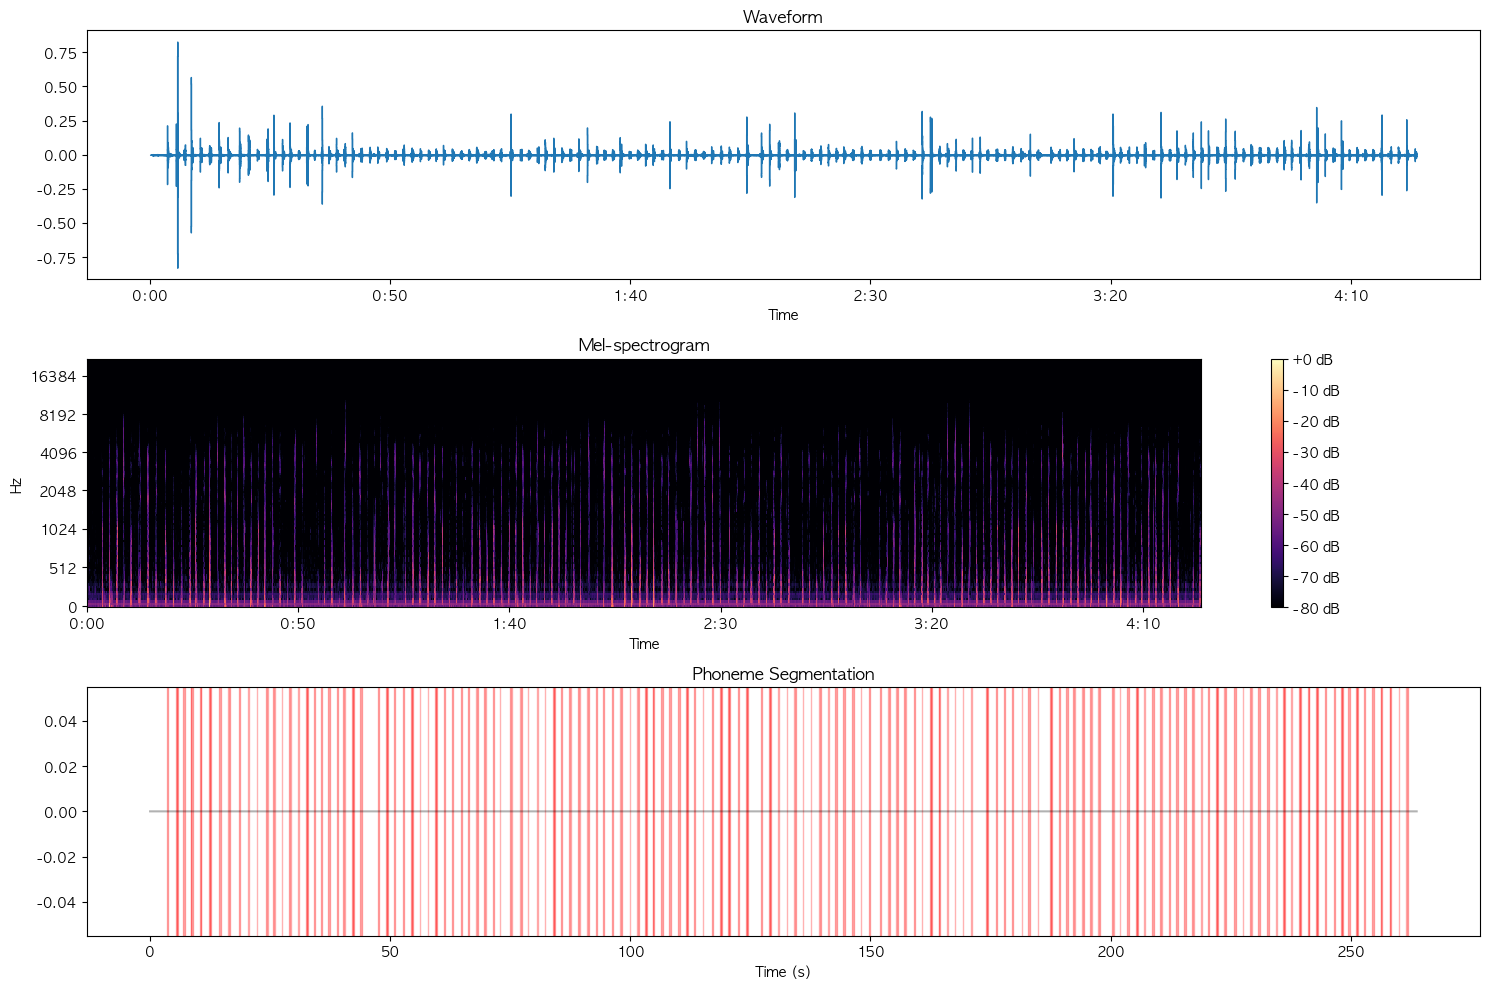


음소 구분 결과:
1. 3.49s - 3.77s: vowel
2. 5.35s - 5.51s: vowel
3. 5.63s - 5.74s: vowel
4. 6.93s - 7.34s: vowel
5. 8.48s - 8.54s: vowel
6. 8.61s - 8.88s: vowel
7. 10.34s - 10.50s: vowel
8. 10.55s - 10.66s: vowel
9. 12.25s - 12.41s: vowel
10. 12.52s - 12.70s: vowel
11. 14.26s - 14.66s: vowel
12. 16.13s - 16.24s: vowel
13. 16.45s - 16.64s: vowel
14. 18.48s - 18.80s: vowel
15. 20.34s - 20.43s: vowel
16. 20.62s - 20.69s: vowel
17. 22.22s - 22.31s: vowel
18. 24.18s - 24.25s: vowel
19. 24.45s - 24.56s: vowel
20. 25.67s - 25.77s: vowel
21. 25.94s - 26.06s: vowel
22. 27.45s - 27.56s: vowel
23. 29.01s - 29.15s: vowel
24. 29.26s - 29.34s: vowel
25. 30.78s - 30.87s: vowel
26. 30.93s - 31.02s: vowel
27. 32.51s - 32.68s: vowel
28. 32.76s - 32.88s: vowel
29. 34.09s - 34.26s: vowel
30. 35.60s - 35.84s: vowel
31. 37.08s - 37.45s: vowel
32. 38.94s - 39.08s: vowel
33. 40.24s - 40.31s: vowel
34. 40.48s - 40.66s: vowel
35. 42.02s - 42.18s: vowel
36. 42.26s - 42.40s: vowel
37. 43.76s - 44.12s: vowel
38. 47.53s 

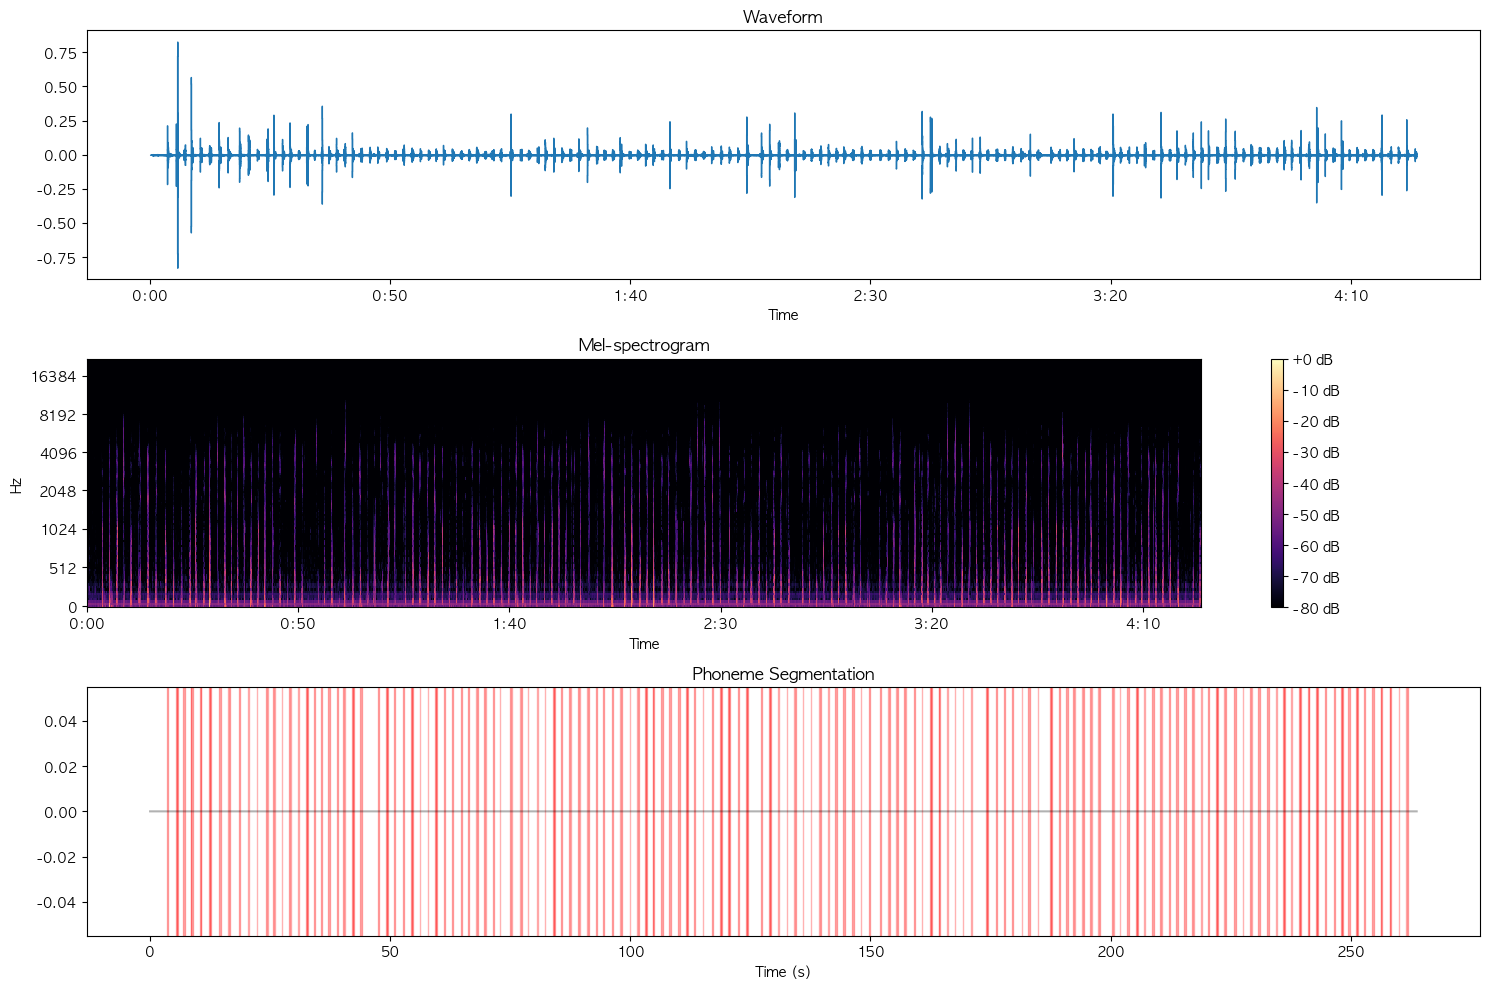


음소 구분 결과:
1. 3.49s - 3.77s: vowel
2. 5.35s - 5.51s: vowel
3. 5.63s - 5.74s: vowel
4. 6.93s - 7.34s: vowel
5. 8.48s - 8.54s: vowel
6. 8.61s - 8.88s: vowel
7. 10.34s - 10.50s: vowel
8. 10.55s - 10.66s: vowel
9. 12.25s - 12.41s: vowel
10. 12.52s - 12.70s: vowel
11. 14.26s - 14.66s: vowel
12. 16.13s - 16.24s: vowel
13. 16.45s - 16.64s: vowel
14. 18.48s - 18.80s: vowel
15. 20.34s - 20.43s: vowel
16. 20.62s - 20.69s: vowel
17. 22.22s - 22.31s: vowel
18. 24.18s - 24.25s: vowel
19. 24.45s - 24.56s: vowel
20. 25.67s - 25.77s: vowel
21. 25.94s - 26.06s: vowel
22. 27.45s - 27.56s: vowel
23. 29.01s - 29.15s: vowel
24. 29.26s - 29.34s: vowel
25. 30.78s - 30.87s: vowel
26. 30.93s - 31.02s: vowel
27. 32.51s - 32.68s: vowel
28. 32.76s - 32.88s: vowel
29. 34.09s - 34.26s: vowel
30. 35.60s - 35.84s: vowel
31. 37.08s - 37.45s: vowel
32. 38.94s - 39.08s: vowel
33. 40.24s - 40.31s: vowel
34. 40.48s - 40.66s: vowel
35. 42.02s - 42.18s: vowel
36. 42.26s - 42.40s: vowel
37. 43.76s - 44.12s: vowel
38. 47.53s 

In [17]:
import librosa
import librosa.display
import librosa.effects as effects
import numpy as np
import matplotlib.pyplot as plt
import parselmouth
from parselmouth import praat
import os
import sounddevice as sd

def load_audio(file_path):
    """
    오디오 파일을 로드합니다.
    
    Args:
        file_path (str): 오디오 파일 경로
    
    Returns:
        tuple: (y, sr) 오디오 데이터와 샘플링 레이트
    """
    y, sr = librosa.load(file_path, sr=None)
    return y, sr

def create_mel_spectrogram(y, sr, n_mels=128):
    """
    Mel-spectrogram을 생성합니다.
    
    Args:
        y (np.ndarray): 오디오 데이터
        sr (int): 샘플링 레이트
        n_mels (int): Mel 필터뱅크 개수
    
    Returns:
        tuple: (mel_spec, times) Mel-spectrogram과 시간축
    """
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    times = librosa.times_like(mel_spec, sr=sr)
    return mel_spec_db, times

def analyze_formants(y, sr):
    """
    포먼트를 분석합니다.
    
    Args:
        y (np.ndarray): 오디오 데이터
        sr (int): 샘플링 레이트
    
    Returns:
        tuple: (f1, f2) F1과 F2 포먼트 값
    """
    # numpy 배열을 Praat Sound 객체로 변환
    sound = parselmouth.Sound(y, sr)
    
    # 포먼트 추출
    formants = sound.to_formant_burg(time_step=0.01, 
                                    max_number_of_formants=5.0,
                                    maximum_formant=5000.0, 
                                    window_length=0.025, 
                                    pre_emphasis_from=50.0)
    
    # 시간에 따른 F1, F2 값 추출
    duration = sound.get_total_duration()
    times = np.arange(0, duration, 0.01)
    f1_values = []
    f2_values = []
    
    for t in times:
        try:
            f1 = formants.get_value_at_time(1, t)
            f2 = formants.get_value_at_time(2, t)
            if f1 and f2:
                f1_values.append(f1)
                f2_values.append(f2)
        except:
            pass
    
    return f1_values, f2_values, times

def detect_phonemes(mel_spec, times, f1_values, f2_values, energy_threshold=0.3, min_duration=0.05):
    """
    자음과 모음을 감지합니다.
    
    Args:
        mel_spec (np.ndarray): Mel-spectrogram
        times (np.ndarray): 시간축
        f1_values (list): F1 포먼트 값
        f2_values (list): F2 포먼트 값
        energy_threshold (float): 에너지 임계값
        min_duration (float): 최소 음소 지속 시간 (초)
    
    Returns:
        list: [(시작 시간, 종료 시간, 음소 타입), ...]
    """
    # 에너지 계산
    energy = np.mean(mel_spec, axis=0)
    energy = (energy - np.min(energy)) / (np.max(energy) - np.min(energy))
    
    # 에너지 임계값을 기준으로 음소 구분
    phonemes = []
    current_start = None
    current_type = None
    current_end = None
    
    for i in range(len(times)):
        if energy[i] > energy_threshold:
            if current_start is None:
                current_start = times[i]
                # F1, F2 값이 있는 경우 모음으로 판단
                if i < len(f1_values) and f1_values[i] > 0 and f2_values[i] > 0:
                    current_type = 'vowel'
                else:
                    current_type = 'consonant'
            current_end = times[i]
        elif current_start is not None:
            # 최소 지속 시간 확인
            if current_end - current_start >= min_duration:
                phonemes.append((current_start, current_end, current_type))
            current_start = None
            current_type = None
            current_end = None
    
    # 마지막 음소 처리
    if current_start is not None and current_end - current_start >= min_duration:
        phonemes.append((current_start, current_end, current_type))
    
    # 너무 짧은 구간 병합
    merged_phonemes = []
    if phonemes:
        current_start, current_end, current_type = phonemes[0]
        for start, end, phoneme_type in phonemes[1:]:
            if phoneme_type == current_type and start - current_end < min_duration:
                current_end = end
            else:
                merged_phonemes.append((current_start, current_end, current_type))
                current_start, current_end, current_type = start, end, phoneme_type
        merged_phonemes.append((current_start, current_end, current_type))
    
    return merged_phonemes

def visualize_results(y, sr, mel_spec, times, phonemes):
    """
    분석 결과를 시각화합니다.
    
    Args:
        y (np.ndarray): 오디오 데이터
        sr (int): 샘플링 레이트
        mel_spec (np.ndarray): Mel-spectrogram
        times (np.ndarray): 시간축
        phonemes (list): 음소 구분 결과
    """
    plt.figure(figsize=(15, 10))
    
    # 파형
    plt.subplot(3, 1, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title('Waveform')
    
    # Mel-spectrogram
    plt.subplot(3, 1, 2)
    librosa.display.specshow(mel_spec, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-spectrogram')
    
    # 음소 구분 결과
    plt.subplot(3, 1, 3)
    for start, end, phoneme_type in phonemes:
        color = 'red' if phoneme_type == 'vowel' else 'blue'
        plt.axvspan(start, end, alpha=0.3, color=color)
    plt.plot(times, np.zeros_like(times), 'k-', alpha=0.3)
    plt.title('Phoneme Segmentation')
    plt.xlabel('Time (s)')
    
    plt.tight_layout()
    plt.show()

def play_audio_segment(y, sr, start_time, end_time):
    """
    오디오의 특정 구간을 재생합니다.
    
    Args:
        y (np.ndarray): 오디오 데이터
        sr (int): 샘플링 레이트
        start_time (float): 시작 시간 (초)
        end_time (float): 종료 시간 (초)
    """
    # 시작과 종료 샘플 인덱스 계산
    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)
    
    # 해당 구간 추출
    segment = y[start_sample:end_sample]
    
    # 재생
    print("재생 중...", end='', flush=True)
    sd.play(segment, sr)
    sd.wait()
    print(" 완료")
    return 0

def analyze_audio_file(file_path, phoneme_number=None):
    """
    오디오 파일을 분석하고 자음/모음을 구분합니다.
    
    Args:
        file_path (str): 오디오 파일 경로
        phoneme_number (int, optional): 재생할 음소 번호. None이면 모든 음소 정보만 반환
    """
    print(f"파일 분석 시작: {file_path}")
    
    # 오디오 로드
    y, sr = load_audio(file_path)
    print(f"오디오 로드 완료: 샘플링 레이트 {sr}Hz")
    
    # Mel-spectrogram 생성
    mel_spec, times = create_mel_spectrogram(y, sr)
    print(f"Mel-spectrogram 생성 완료: {len(times)} 프레임")
    
    # 포먼트 분석
    f1_values, f2_values, formant_times = analyze_formants(y, sr)
    print(f"포먼트 분석 완료: {len(f1_values)} 포인트")
    
    # 음소 구분
    phonemes = detect_phonemes(mel_spec, times, f1_values, f2_values)
    print(f"음소 구분 완료: {len(phonemes)} 개의 음소 발견")
    
    # 결과 시각화
    visualize_results(y, sr, mel_spec, times, phonemes)
    
    # 결과 출력
    print("\n음소 구분 결과:")
    for i, (start, end, phoneme_type) in enumerate(phonemes):
        print(f"{i+1}. {start:.2f}s - {end:.2f}s: {phoneme_type}")
    
    # 특정 음소 재생
    if phoneme_number is not None:
        try:
            idx = phoneme_number - 1
            if 0 <= idx < len(phonemes):
                start, end, phoneme_type = phonemes[idx]
                print(f"\n{phoneme_type} 재생 중...")
                play_audio_segment(y, sr, start, end)
            else:
                print(f"올바른 번호를 입력하세요. (1-{len(phonemes)})")
        except KeyboardInterrupt:
            print("\n재생이 중단되었습니다.")
    
    return phonemes, y, sr  # y와 sr도 함께 반환하도록 수정

def main():
    # 파일 경로 설정
    file_path = "../../../../Desktop/results/participant_038/038_stage4_20250416_1809.wav"
    
    if not os.path.exists(file_path):
        print("파일이 존재하지 않습니다.")
        return
    
    try:
        # 음소 분석만 수행
        phonemes, y, sr = analyze_audio_file(file_path)
        
        # 예시: 첫 번째 음소 재생
        if phonemes:
            analyze_audio_file(file_path, phoneme_number=1)
    except Exception as e:
        print(f"분석 중 오류 발생: {str(e)}")

if __name__ == "__main__":
    main() 

# For test sample

In [2514]:
audio_list

['22_stage1_20250404_1111.wav',
 '22_stage2_20250404_1112.wav',
 '22_stage3_20250404_1114.wav',
 '22_stage4_20250404_1114.wav',
 '22_stage5_20250404_1120.wav',
 '22_stage6_20250404_1125.wav']

In [2530]:
audio_path

'../../../../Desktop/results/participant_LY022(v)/22_stage4_20250404_1114.wav'

../../../../Desktop/results/participant_LY022(v)/22_stage4_20250404_1114.wav
(13, 133)


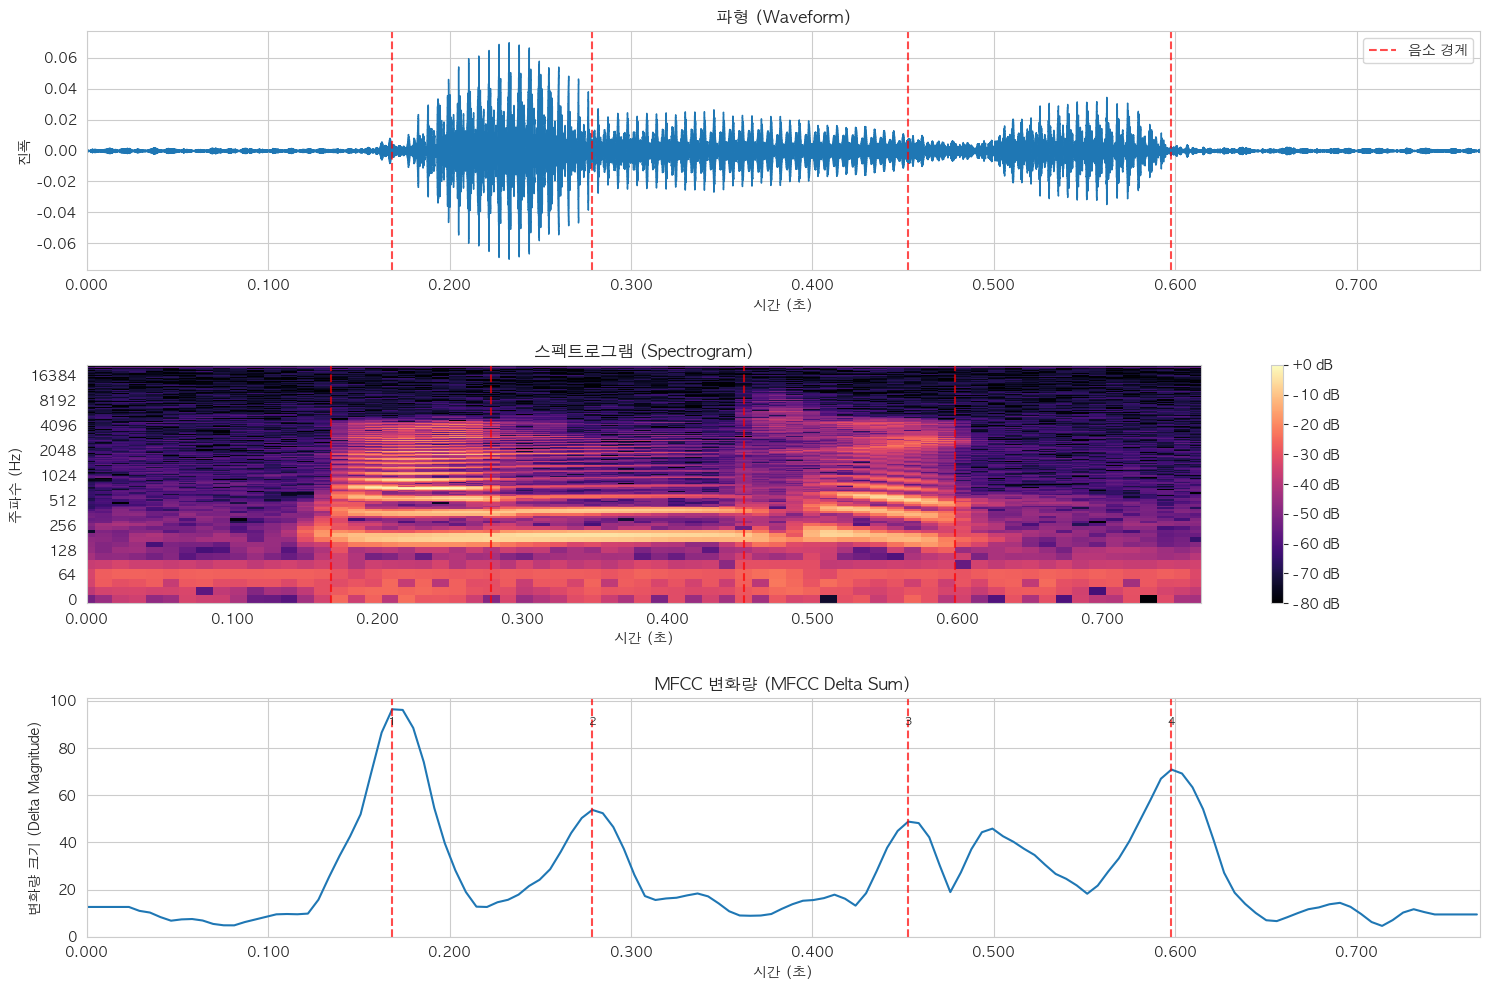

총 4개의 음소 경계 탐지
음소 경계 1: 0.168초
음소 경계 2: 0.279초
음소 경계 3: 0.453초
음소 경계 4: 0.598초


In [2531]:
print(audio_path)
segments = visualize_phoneme_segmentation(audio_path, start_time=start_time_list[16], end_time=end_time_list[16])

[0.04063492 0.16834467 0.30185941 0.5630839  0.69659864]
63.650999999999996
filePath ../../../../Desktop/results/participant_LY022(v)
audio_name 22_stage2_20250404_1112.wav
[0.04063492 0.16834467 0.30185941 0.5630839  0.69659864]
63.650999999999996
filePath ../../../../Desktop/results/participant_LY022(v)
audio_name 22_stage2_20250404_1112.wav
[0.04063492 0.16834467 0.30185941 0.5630839  0.69659864]
63.650999999999996
filePath ../../../../Desktop/results/participant_LY022(v)
audio_name 22_stage2_20250404_1112.wav
[0.04063492 0.16834467 0.30185941 0.5630839  0.69659864]
63.650999999999996
filePath ../../../../Desktop/results/participant_LY022(v)
audio_name 22_stage2_20250404_1112.wav
[0.04063492 0.16834467 0.30185941 0.5630839  0.69659864]
63.650999999999996


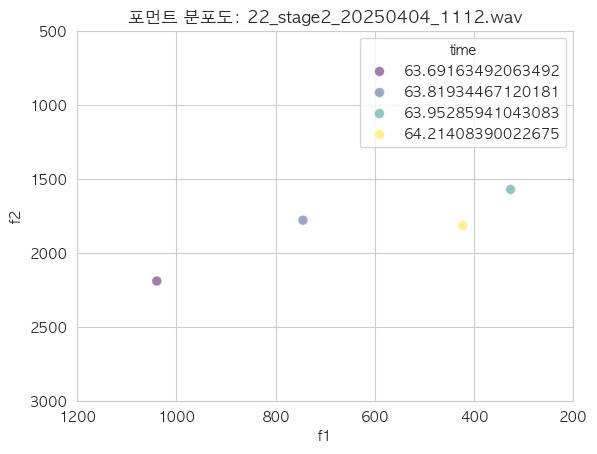

In [2506]:
# 통짜 파일이니 offset이 필요하겠네,,
stage = 1
data_exp = None
for idx in range(len(segments)):
    print(segments)
    print(start_time_list[34])
    if idx == len(segments)-1:
        continue
    if data_exp is None:
        data_exp = formant_analysis(participant_path, audio_list[stage], start_time=start_time_list[34]+ segments[idx], end_time=start_time_list[34]+segments[idx+1], time_step=-1)
    else:
        data_exp = pd.concat([data_exp, formant_analysis(participant_path, audio_list[stage], start_time=start_time_list[34]+ segments[idx], end_time=start_time_list[34]+segments[idx+1], time_step=-1)])
    

sns.scatterplot(data=data_exp, x="f1", y="f2", hue="time", palette="viridis", alpha=0.5, s=50)
ax = plt.gca()
ax.set_xlim(F1_MAX, F1_MIN)
ax.set_ylim(F2_MAX, F2_MIN)
plt.title(f"포먼트 분포도: {audio_list[stage]}")
plt.show()

[0.16834467 0.27863946 0.45278912 0.59791383]
35.699
filePath ../../../../Desktop/results/participant_LY022(v)
audio_name 22_stage4_20250404_1114.wav
[0.16834467 0.27863946 0.45278912 0.59791383]
35.699
filePath ../../../../Desktop/results/participant_LY022(v)
audio_name 22_stage4_20250404_1114.wav
[0.16834467 0.27863946 0.45278912 0.59791383]
35.699
filePath ../../../../Desktop/results/participant_LY022(v)
audio_name 22_stage4_20250404_1114.wav
[0.16834467 0.27863946 0.45278912 0.59791383]
35.699


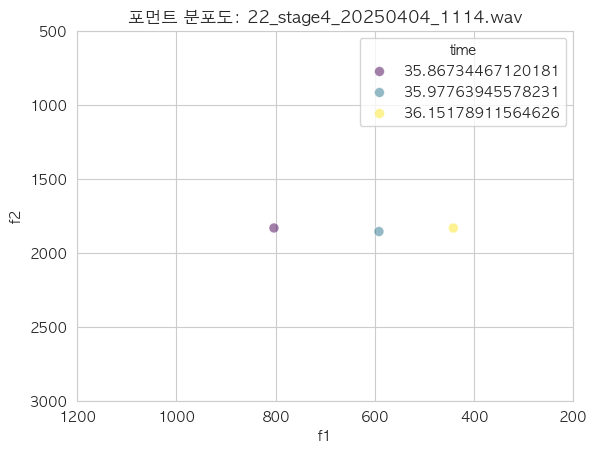

In [2533]:
# 통짜 파일이니 offset이 필요하겠네,,
stage = 3
data_exp = None
for idx in range(len(segments)):
    print(segments)
    print(start_time_list[16])
    if idx == len(segments)-1:
        continue
    if data_exp is None:
        data_exp = formant_analysis(participant_path, audio_list[stage], start_time=start_time_list[16]+ segments[idx], end_time=start_time_list[16]+segments[idx+1], time_step=-1)
    else:
        data_exp = pd.concat([data_exp, formant_analysis(participant_path, audio_list[stage], start_time=start_time_list[16]+ segments[idx], end_time=start_time_list[16]+segments[idx+1], time_step=-1)])
    

sns.scatterplot(data=data_exp, x="f1", y="f2", hue="time", palette="viridis", alpha=0.5, s=50)
ax = plt.gca()
ax.set_xlim(F1_MAX, F1_MIN)
ax.set_ylim(F2_MAX, F2_MIN)
plt.title(f"포먼트 분포도: {audio_list[stage]}")
plt.show()

[0.14512472 0.29605442 0.49922902 0.62113379]
58.034
filePath ../../../../Desktop/results/participant_LY022(v)
audio_name 22_stage6_20250404_1125.wav
[0.14512472 0.29605442 0.49922902 0.62113379]
58.034
filePath ../../../../Desktop/results/participant_LY022(v)
audio_name 22_stage6_20250404_1125.wav
[0.14512472 0.29605442 0.49922902 0.62113379]
58.034
filePath ../../../../Desktop/results/participant_LY022(v)
audio_name 22_stage6_20250404_1125.wav
[0.14512472 0.29605442 0.49922902 0.62113379]
58.034


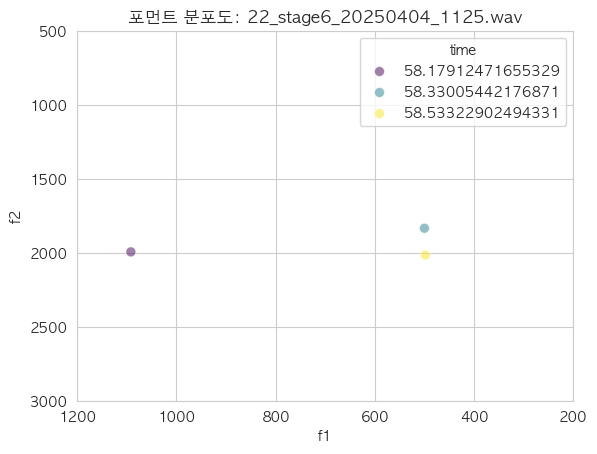

In [2513]:
# 통짜 파일이니 offset이 필요하겠네,,
stage = 5
data_exp = None
for idx in range(len(segments)):
    print(segments)
    print(start_time_list[34])
    if idx == len(segments)-1:
        continue
    if data_exp is None:
        data_exp = formant_analysis(participant_path, audio_list[stage], start_time=start_time_list[34]+ segments[idx], end_time=start_time_list[34]+segments[idx+1], time_step=-1)
    else:
        data_exp = pd.concat([data_exp, formant_analysis(participant_path, audio_list[stage], start_time=start_time_list[34]+ segments[idx], end_time=start_time_list[34]+segments[idx+1], time_step=-1)])
    

sns.scatterplot(data=data_exp, x="f1", y="f2", hue="time", palette="viridis", alpha=0.5, s=50)
ax = plt.gca()
ax.set_xlim(F1_MAX, F1_MIN)
ax.set_ylim(F2_MAX, F2_MIN)
plt.title(f"포먼트 분포도: {audio_list[stage]}")
plt.show()